# Baseline

We establish a strong baseline in this notebook with:
- Local Outlier Factor (LOF),
- One-Class SVM,
- Isolation Forest,
- Autoencoder.

We chose the MNIST dataset for this benchmark, excluding the digit *9* from the training data: *9* shall be considered the anomalous data.

In [1]:
import os

import numpy as np
np.random.seed(0)
np.set_printoptions(suppress=True)

from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import fetch_mldata
from sklearn import metrics
from sklearn.model_selection import train_test_split

import pandas as pd

import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mnist = fetch_mldata('MNIST original', data_home='.', )
mnist.data = mnist.data.astype(np.float32)
mnist.data = (mnist.data - np.mean(mnist.data)) / np.std(mnist.data)

In [3]:
X = mnist.data[mnist.target != 7]
Y = mnist.target[mnist.target != 7]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)
X_anomalies_full = mnist.data[mnist.target == 7]

X_random = np.random.uniform(size=(10000, 784))

Subsample the anomalies.

In [4]:
rate = .05
size = np.min((int(rate * X_train.shape[0]), X_anomalies_full.shape[0]))
idx = np.random.choice(range(X_anomalies_full.shape[0]), size=size, replace=False)
X_anomalies = X_anomalies_full[idx]

Some dimensionality reduction.

In [5]:
from sklearn import decomposition

In [6]:
pca30 = decomposition.PCA(n_components=30)
mnist_pca30 = pca30.fit_transform(X_train)

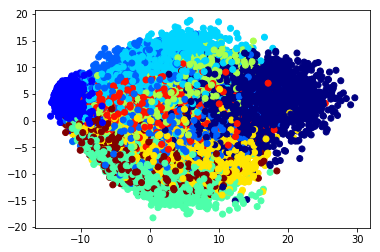

In [7]:
plt.scatter(*zip(*mnist_pca30[:, :2]), c=Y_train, cmap='jet')

Some helper functions.

In [29]:
def calc_pr(scores, labels, plot=False):
    """
    Given scores and labels, returns the precision, recall, thresholds and
    area under the curve.
    
    Params:
        scores      (1d-numpy array): low scores should represent anomalies.
        labels      (1d-numpy array): same shape as `score`, `1` is for anonaly,
                                      `0` for normal data.
        plot                  (bool): if `True`, plots the precision-recall curve.
    
    Returns:
        precision, recall, thresholds, area under the curve
    """
    if scores.ndim != 1:
        raise ValueError('`scores` has %i dimensions instead of 1.' % scores.ndim)
    if not isinstance(scores, np.ndarray):
        scores = np.array(scores)
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)
    
    idx = np.argsort(scores)
    ascores = scores[idx]
    alabels = labels[idx]
    tps = np.cumsum(alabels).astype(np.float32)
    fps = np.arange(tps.shape[0]) + 1. - tps
    recall = tps / np.sum(alabels)
    precision = np.divide(tps, tps + fps, out=np.zeros_like(tps), where=(tps + fps)!=0.)
    auc = np.trapz(precision, recall)
    
    if plot:
        plot_pr(precision, recall, auc)
    return precision, recall, ascores, auc


def plot_pr(precision, recall, auc=None):
    plt.plot(recall, precision)
    plt.ylim((0., 1.1))
    plt.xlim((0., 1.1))
    plt.ylabel('precision')
    plt.xlabel('recall');
    plt.title('Precision-Recall curve (AUC = %s)\n' % ('%.3f' % auc if auc else 'N/A'), size=14)
    plt.show

## 1. Isolation Forest

In [13]:
iforest = IsolationForest(contamination=.0, n_estimators=500,n_jobs=-1)

In [14]:
iforest.fit(X_train)

IsolationForest(bootstrap=False, contamination=0.0, max_features=1.0,
        max_samples='auto', n_estimators=500, n_jobs=-1, random_state=None,
        verbose=0)

In [15]:
y_pred_test = iforest.decision_function(X_test)
y_pred_anomalies = iforest.decision_function(X_anomalies)
y_pred_random = iforest.decision_function(X_random)

In [16]:
y_pred_anomalies.shape

(1567,)

/home/bmyara/miniconda2/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


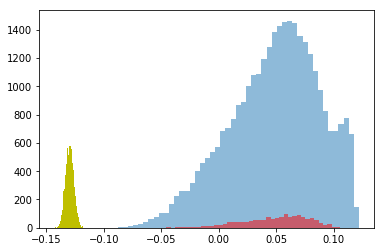

In [17]:
plt.hist(y_pred_test, bins=50, normed=False, alpha=.5);
plt.hist(y_pred_anomalies, bins=50, color='red', normed=False, alpha=.5)
plt.hist(y_pred_random, bins=50, color='y');

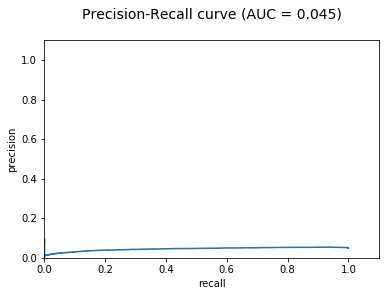

In [18]:
scores = np.concatenate([y_pred_anomalies, y_pred_test])
labels = np.array([1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0])
p, r, t, auc = calc_pr(scores, labels)
plot_pr(p, r, auc)

The results are pretty bad. Let's use PCA on the data beforehand.

In [19]:
varE = [.1, .2, .3, .4, .5, .6, .7, .85, .9, .95, .98, .99, .9999999, 1.]
aucs = []
for v in varE:
    
    # (1) Dimensionality reduction
    print('*' * 20)
    pca = decomposition.PCA(v) if v != 1. else decomposition.PCA()
    X_train_pca = pca.fit_transform(X_train)
    print(' explained variance = %.2f - n components = %i' % (v, pca.n_components_))
    
    # Isolation Forest
    iforest = IsolationForest(contamination=.0, n_jobs=-1, n_estimators=500)
    iforest.fit(X_train_pca)
    X_test_pca, X_anomalies_pca = pca.transform(X_test), pca.transform(X_anomalies)
    y_pred_test = iforest.decision_function(X_test_pca)
    y_pred_anomalies = iforest.decision_function(X_anomalies_pca)
    scores = np.concatenate([y_pred_anomalies, y_pred_test])
    labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]

    p, r, t, auc = calc_pr(scores, labels)
    aucs.append(auc)
    print('AUC = %.3f' % auc)

********************
 explained variance = 0.10 - n components = 1
AUC = 0.036
********************
 explained variance = 0.20 - n components = 3
AUC = 0.033
********************
 explained variance = 0.30 - n components = 5
AUC = 0.031
********************
 explained variance = 0.40 - n components = 7
AUC = 0.031
********************
 explained variance = 0.50 - n components = 11
AUC = 0.038
********************
 explained variance = 0.60 - n components = 17
AUC = 0.060
********************
 explained variance = 0.70 - n components = 26
AUC = 0.049
********************
 explained variance = 0.85 - n components = 58
AUC = 0.054
********************
 explained variance = 0.90 - n components = 86
AUC = 0.055
********************
 explained variance = 0.95 - n components = 150
AUC = 0.059
********************
 explained variance = 0.98 - n components = 254
AUC = 0.064
********************
 explained variance = 0.99 - n components = 324
AUC = 0.083
********************
 explained variance 

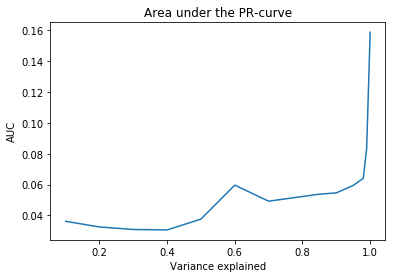

In [20]:
plt.plot(varE, aucs)
plt.title('Area under the PR-curve')
plt.xlabel('Variance explained')
plt.ylabel('AUC');

/home/bmyara/miniconda2/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


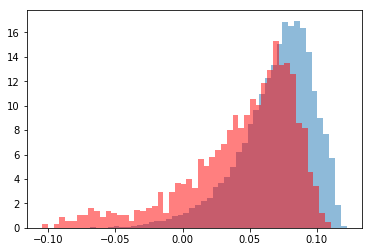

In [22]:
plt.hist(y_pred_test, bins=50, normed=True, alpha=.5);
plt.hist(y_pred_anomalies, bins=50, color='red', normed=True, alpha=.5);

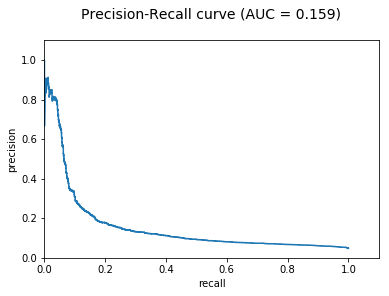

In [23]:
plot_pr(p, r, auc)

## 2. Local Outlier Factor

In [24]:
from sklearn.neighbors import LocalOutlierFactor

In [25]:
pca = decomposition.PCA(.8)
X_pca = pca.fit_transform(X_train)
A_pca = pca.transform(X_anomalies)
Xt_pca = pca.transform(X_test)

In [27]:
# lof = LocalOutlierFactor(contamination=0.001)
# lof.fit(X_pca)

In [28]:
# A_lof = lof._decision_function(A_pca)
# X_lof = lof._decision_function(Xt_pca)

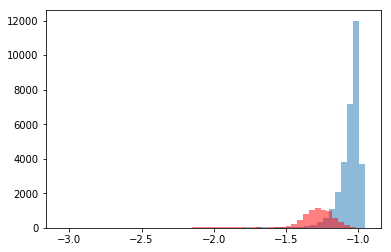

In [58]:
# plt.hist(X_lof, bins=50, alpha=.5);
# plt.hist(A_lof, bins=50, color='red', alpha=.5);

In [145]:
# scores = np.concatenate([A_lof, X_lof])
# labels = np.array([1] * A_lof.shape[0] + [0] * X_lof.shape[0])
# p, r, t, auc = calc_pr(scores, labels)
# plot_pr(p, r, auc)

In [29]:
varE = [.1, .2, .3, .4, .5, .6, .7, .8, .82, .85, .9]
aucs = []
for v in varE:
    
    # (1) Dimensionality reduction
    print('*' * 20)
    pca = decomposition.PCA(v) if v != 1. else decomposition.PCA()
    X_train_pca = pca.fit_transform(X_train)
    print(' explained variance = %.2f - n components = %i' % (v, pca.n_components_))
    #X_train_pca = pca.transform(X_train)
    
    # Isolation Forest
    localOut = LocalOutlierFactor(contamination=.001)
    localOut.fit(X_train_pca)
    X_test_pca, X_anomalies_pca = pca.transform(X_test), pca.transform(X_anomalies)
    y_pred_test = localOut._decision_function(X_test_pca)
    y_pred_anomalies = localOut._decision_function(X_anomalies_pca)    
    
    
    scores = np.concatenate([y_pred_anomalies, y_pred_test])
    labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]

    p, r, t, auc = calc_pr(scores, labels)
    aucs.append(auc)
    print('AUC = %.3f' % auc)

********************
 explained variance = 0.10 - n components = 1
AUC = 0.047
********************
 explained variance = 0.20 - n components = 3
AUC = 0.044
********************
 explained variance = 0.30 - n components = 5
AUC = 0.078
********************
 explained variance = 0.40 - n components = 7
AUC = 0.116
********************
 explained variance = 0.50 - n components = 11
AUC = 0.300
********************
 explained variance = 0.60 - n components = 17
AUC = 0.374
********************
 explained variance = 0.70 - n components = 26
AUC = 0.403
********************
 explained variance = 0.80 - n components = 43
AUC = 0.434
********************
 explained variance = 0.82 - n components = 48
AUC = 0.430
********************
 explained variance = 0.85 - n components = 58
AUC = 0.419
********************
 explained variance = 0.90 - n components = 86
AUC = 0.400


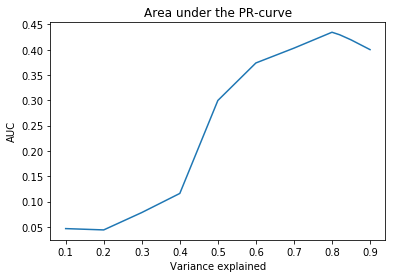

In [30]:
plt.plot(varE, aucs)
plt.title('Area under the PR-curve')
plt.xlabel('Variance explained')
plt.ylabel('AUC');

/home/bmyara/miniconda2/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


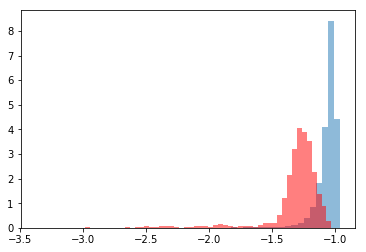

In [32]:
plt.hist(y_pred_test, bins=50, normed=True, alpha=.5);
plt.hist(y_pred_anomalies, bins=50, color='red', normed=True, alpha=.5);

## 3. One-class SVM

In [33]:
from sklearn.svm import OneClassSVM

In [34]:
#svm = OneClassSVM(nu=.01)
svm = OneClassSVM()

In [36]:
pca = decomposition.PCA(.5)
X_pca = pca.fit_transform(X_train)
A_pca = pca.transform(X_anomalies)
Xt_pca = pca.transform(X_test)
R_pca = pca.transform(X_random)

In [37]:
svm.fit(X_pca)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [38]:
A_svm = svm.decision_function(A_pca)
Xt_svm = svm.decision_function(Xt_pca)
R_svm = svm.decision_function(R_pca)
R_svm = svm.decision_function(R_pca)

/home/bmyara/miniconda2/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


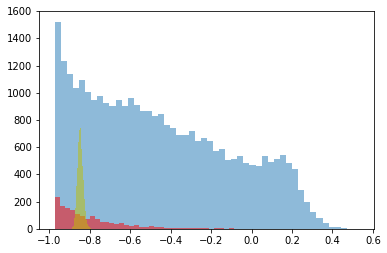

In [41]:
normed = False
plt.hist(Xt_svm, bins=50, normed=normed, alpha=.5);
plt.hist(A_svm, bins=50, normed=normed, color='red', alpha=.5);
plt.hist(R_svm, bins=50, normed=normed, color='y', alpha=.5);

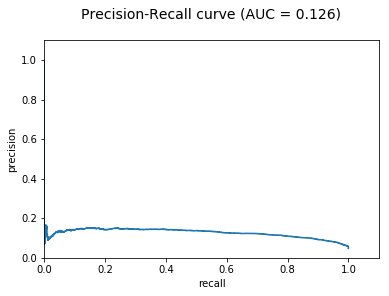

In [42]:
scores = np.concatenate([A_svm, Xt_svm])[:, 0]
labels = np.array([1] * A_svm.shape[0] + [0] * Xt_svm.shape[0])
p, r, t, auc = calc_pr(scores, labels)
plot_pr(p, r, auc)

In [43]:
varE = [.1, .2, .3, .4, .5, .6, .7, .8, .85, .9]
aucs = []
for v in varE:
    
    # (1) Dimensionality reduction
    print('*' * 20)
    pca = decomposition.PCA(v) if v != 1. else decomposition.PCA()
    X_train_pca = pca.fit_transform(X_train)
    print(' explained variance = %.2f - n components = %i' % (v, pca.n_components_))
    #X_train_pca = pca.transform(X_train)
    
    # Isolation Forest
    svm = OneClassSVM(nu=.01)
    svm.fit(X_train_pca)
    X_test_pca, X_anomalies_pca = pca.transform(X_test), pca.transform(X_anomalies)
    y_pred_test = svm.decision_function(X_test_pca)
    y_pred_anomalies = svm.decision_function(X_anomalies_pca)
    
    scores = np.concatenate([y_pred_anomalies, y_pred_test])[:, 0]
    labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]

    p, r, t, auc = calc_pr(scores, labels)
    aucs.append(auc)
    print('AUC = %.3f' % auc)

********************
 explained variance = 0.10 - n components = 1
AUC = 0.056
********************
 explained variance = 0.20 - n components = 3
AUC = 0.045
********************
 explained variance = 0.30 - n components = 5
AUC = 0.052
********************
 explained variance = 0.40 - n components = 7
AUC = 0.062
********************
 explained variance = 0.50 - n components = 11
AUC = 0.126
********************
 explained variance = 0.60 - n components = 17
AUC = 0.165
********************
 explained variance = 0.70 - n components = 26
AUC = 0.162
********************
 explained variance = 0.80 - n components = 43
AUC = 0.169
********************
 explained variance = 0.85 - n components = 58
AUC = 0.150
********************
 explained variance = 0.90 - n components = 86
AUC = 0.140


## 4. Autoencoder

In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim
from utils import progress, count_parameters, visualize, get_batch

cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))

Training on GPU


In [9]:
mnist = fetch_mldata('MNIST original', data_home='.', )
mnist.data = mnist.data.astype(np.float32)
mnist.data = mnist.data / 255.

In [10]:
X = mnist.data[mnist.target != 7]
Y = mnist.target[mnist.target != 7]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)
X_anomalies_full = mnist.data[mnist.target == 7]

X_random = np.random.uniform(size=(10000, 784))

rate = .05
size = np.min((int(rate * X_train.shape[0]), X_anomalies_full.shape[0]))
idx = np.random.choice(range(X_anomalies_full.shape[0]), size=size, replace=False)
X_anomalies = X_anomalies_full[idx]

In [468]:
pca = decomposition.PCA(.8)
X_pca = pca.fit_transform(X_train)
A_pca = pca.transform(X_anomalies)
Xt_pca = pca.transform(X_test)
R_pca = pca.transform(X_random)

In [469]:
n_dim = X_pca.shape[1]
print(n_dim)

43


In [329]:
def tonumpy(x):
    return x.data.cpu().numpy()


def evaluate(net, data, shape, norm='fro'):
    shape = tuple([-1] + shape)
    output = []
    for j, x in enumerate(get_batch(data, batch_size, allow_smaller_batch=True)):
        xt = Variable(torch.from_numpy(x).type(FloatTensor))
        xt = xt.view(shape)
        output.append(np.linalg.norm(x.reshape(-1, np.prod(shape[1:])) - net(xt).data.cpu().numpy().reshape((-1, np.prod(shape[1:]))), axis=1, ord=norm))
    return np.concatenate(output)

In [507]:
z = 16
net2 = nn.Sequential(
                # Encoder
                nn.Linear(n_dim, 512),
                nn.ReLU(),
                #nn.BatchNorm1d(512),
                nn.Linear(512, 128),
                nn.ReLU(),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
    
                # Low-dimensional representation
                nn.Linear(128, z),
                nn.ReLU(),
                #nn.BatchNorm1d(z),
    
                # Decoder
                nn.Linear(z, 128),
                nn.ReLU(),
    
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
                #nn.BatchNorm1d(128),
                nn.Linear(128, 512),
                nn.ReLU(),
                nn.Linear(512, n_dim)).type(FloatTensor)
                #nn.Sigmoid()).type(FloatTensor)
count_parameters(net2)
optimizer = torch.optim.Adamax(params=net2.parameters(), lr=0.01)

180,539 parameters
180,539 trainable parameters


In [488]:
# z = 1 # default=8
# net2  = nn.Sequential(
#                 # Encoder
#                 nn.Conv2d(1, 32, 3, padding=1), # input (1, 28, 28), output (32, 28, 28)
#                 nn.PReLU(32),
#                 nn.BatchNorm2d(32),
#                 nn.MaxPool2d(2), # (32, 14, 14)
#                 nn.Conv2d(32, 64, 3), # (64, 12, 12)
#                 nn.PReLU(64),
#                 nn.BatchNorm2d(64),
#                 nn.MaxPool2d(2), # (64, 6, 6))
                
#                 # Low-dimensional representation
#                 nn.Conv2d(64, z, 3), # (8, 4, 4) -- latent representation
#                 nn.PReLU(z),
#                 nn.BatchNorm2d(z),
                
#                 # Decoder
#                 nn.Conv2d(z, 64, 3, padding=2), # (64, 6, 6)
#                 nn.Upsample(scale_factor=2), # (64, 12, 12)
#                 nn.Conv2d(64, 32, 3, padding=2), # (32, 14, 14)
#                 nn.PReLU(32),
#                 nn.Upsample(scale_factor=2), # (32, 28, 28)
#                 nn.Conv2d(32, 1, 3, padding=1),
#                 nn.Sigmoid()).type(FloatTensor).type(FloatTensor)
# count_parameters(net2)
# optimizer = torch.optim.Adam(params=net2.parameters(), lr=0.01)

In [508]:
max_epochs = 100
batch_size = 300
N = X_train.shape[0]
# optimizer.param_groups[0]['lr'] = 0.01
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    net2.train()
    for j, x in enumerate(get_batch(X_pca, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).type(FloatTensor))
        x = x.view(x.size(0), -1)
        #x = x.view((-1, 1, 28, 28))
        net2.zero_grad()
        x_ = net2(x)
        loss = torch.dist(x, x_) 
        #loss = torch.nn.BCELoss()(x_, x) * batch_size
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start, net2, mnist.data[:55000], in_size=[28*28])
    else:
        if i % 20 == 0 and i != 0:
            optimizer.param_groups[0]['lr'] /= 2.
            print(optimizer.param_groups[0]['lr'])
            
        shape = [n_dim]
        norm = None
        net2.eval()
        y_pred_test = evaluate(net2, Xt_pca, shape, norm=norm)
        y_pred_anomalies = evaluate(net2, A_pca, shape, norm=norm)

        mean_normal = np.mean(y_pred_test)
        mean_anomaly = np.mean(y_pred_anomalies)
        scores = -np.concatenate([y_pred_anomalies, y_pred_test])

        labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]
        p, r, t, auc = calc_pr(scores, labels)
        print('\x1b[31m%.3f - auc = %.3f\x1b[0m' % (mean_anomaly / mean_normal, auc))


[  1/100][==================================================] 100% – loss 71.89677 -    0s [58054 fps]
1.342 - auc = 0.181
[  2/100][==================================================] 100% – loss 51.31893 -    0s [81845 fps]
1.391 - auc = 0.169
[  3/100][==================================================] 100% – loss 47.05217 -    0s [68015 fps]
1.447 - auc = 0.198
[  4/100][==================================================] 100% – loss 44.86033 -    0s [54208 fps]
1.462 - auc = 0.204
[  5/100][==================================================] 100% – loss 43.44688 -    0s [58799 fps]
1.459 - auc = 0.187
[  6/100][==================================================] 100% – loss 42.37076 -    0s [77966 fps]
1.494 - auc = 0.207
[  7/100][==================================================] 100% – loss 41.45527 -    0s [75440 fps]
1.444 - auc = 0.182
[  8/100][==================================================] 100% – loss 40.75418 -    0s [81461 fps]
1.495 - auc = 0.208
[  9/100][======

In [181]:
# net2.eval()
# visualize(net2, mnist.data[:55000], in_size=[28*28], dtype=FloatTensor)

In [439]:
# shape = [1, 28, 28]
shape = [n_dim]
norm = None
net2.eval()
y_pred_test = evaluate(net2, Xt_pca, shape, norm=norm)
y_pred_anomalies = evaluate(net2, A_pca, shape, norm=norm)

mean_normal = np.mean(y_pred_test)
mean_anomaly = np.mean(y_pred_anomalies)
print(mean_normal, mean_anomaly, mean_anomaly / mean_normal)

2.5933132 4.5132947 1.7403585


In [242]:
# visualize(net2, X_pca, in_size=[1, 28*28], dtype=FloatTensor)

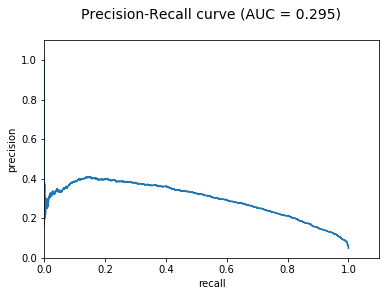

In [440]:
scores = -np.concatenate([y_pred_anomalies, y_pred_test])

labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]
p, r, t, auc = calc_pr(scores, labels, plot=True)

/home/bmyara/miniconda2/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


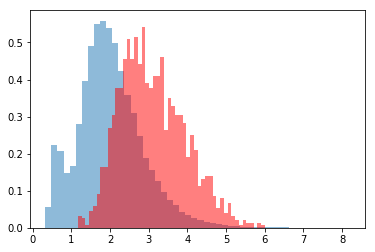

In [504]:
plt.hist(y_pred_test, bins=50, normed=True, alpha=.5);
plt.hist(y_pred_anomalies, bins=50, color='red', normed=True, alpha=.5);

In [384]:
visualize(net2, mnist.data[:55000], in_size=[28*28], dtype=FloatTensor)

RuntimeError: size mismatch, m1: [10 x 784], m2: [43 x 512] at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THC/generic/THCTensorMathBlas.cu:249